In [40]:
%matplotlib inline

from matplotlib import pyplot as pl
from scipy.integrate import odeint
import numpy as np

# A solar system simulator demonstration in python

This notebook shows a simple solar system simulator (or in reality any general N-body gravitational interaction simulator) using python.

Firstly we'll define a function that defines the coupled ordinary differential equations that are required. For the motion of body $i$, under the influence of the gravitational field of body $j$, we have:

$$
\frac{{\rm d}x_i}{{\rm d}t} = v_{x,i}, \frac{{\rm d}y_i}{{\rm d}t} = v_{y,i}, \frac{{\rm d}z_i}{{\rm d}t} = v_{z,i},
$$

and

$$
\frac{{\rm d}v_{x,i}}{{\rm d}t} = a_{x,i} \equiv \frac{F_{x,i}}{m_i} = \frac{Gm_j \hat{r}_x}{r^2} = \frac{Gm_j \left(x_j-x_i\right)}{r^3},
$$

$$
\frac{{\rm d}v_{y,i}}{{\rm d}t} = \frac{Gm_j \left(y_j-y_i\right)}{r^3},
$$

$$
\frac{{\rm d}v_{z,i}}{{\rm d}t} = \frac{Gm_j \left(z_j-z_i\right)}{r^3},
$$

where $r = \left(\left(x_j-x_i\right)^2 + \left(y_j-y_i\right)^2 + \left(z_j-z_i\right)^2 \right)^{1/2}$.

In [41]:
def grav(x, t, masses):
    """
    Coupled differential equations for computing the gravitational
    attraction between n-bodies.

    Args:
        x (:class:`numpy.ndarray`): an array containing the 3D position and velocity vectors of
            each of then bodies, e.g. for [x1, y1, z1, vx1, vy1, vz1, ... ]
        t (float): a time
        masses (list): a list of masses multiplied by G for each bodies, in units using AUs and
           days 
    """

    # number of bodies
    N = len(masses)

    Y = np.zeros(6*N)
    # coupled differential equations
    # x = [x,y,z,vx,vy,vz]

    # 3D orbits
    for i in range(N):
        # dx/dt = v
        Y[6*i:6*i+3] = x[6*i+3:6*i+6]

        for j in range(N):
            if i != j:
                r = np.sqrt(np.sum((x[6*j:6*j+3]-x[6*i:6*i+3])**2))

                # dv/dt = a  (a = F/m) (F = GMm|x2-x1|/r^3)
                Y[6*j+3:6*j+6] += masses[i]*(x[6*i:6*i+3]-x[6*j:6*j+3])/r**3         

    return Y

To initialise the solar system (positions and velocities), to start with just the Earth/Moon system and Sun, we can use the JPL ephemeris values (e.g., those found [here](http://www.astro.gla.ac.uk/honours/labs/solar_system/JPL%20coordinates/)). We also need masses of the planets, which are given as ratios to the mass of the Sun, which in turn is defined though the [Gaussian gravitational constant](https://en.wikipedia.org/wiki/Gaussian_gravitational_constant), [here](http://www.astro.gla.ac.uk/honours/labs/solar_system/astro_constants.html).

In [42]:
# set masses (Earth and Sun)
GM = [(0.01720209895)**2/328900.56, (0.01720209895)**2]  # see http://www.astro.gla.ac.uk/honours/labs/solar_system/astro_constants.html

# set up the initial position of the Earth in units of AU and AU/day:
X = np.zeros(2*6)

# Earth's initial position and velocity
X[0] = -1.756895992827094E-01
X[1] =  9.659716383076408E-01
X[2] = 2.050240276128469E-04
X[3] = -1.722463621150023E-02
X[4] = -3.020684839068507E-03
X[5] = -7.003389133678563E-08

# Sun's initial position and velocity
X[6] = -7.139147132286038E-03
X[7] = -2.792019830280757E-03
X[8] = 2.061825715444439E-04
X[9] = 5.374261407019511E-06
X[10] = -7.410966744915032E-06
X[11] = -9.422889366172143E-08

# set the timestamps at which the solver will work (note that this does not use adaptive step sizes)
times = np.arange(0., 3650.) # ten years with one step per day

y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)


Now, we can plot the positions of the two bodies in 3D.

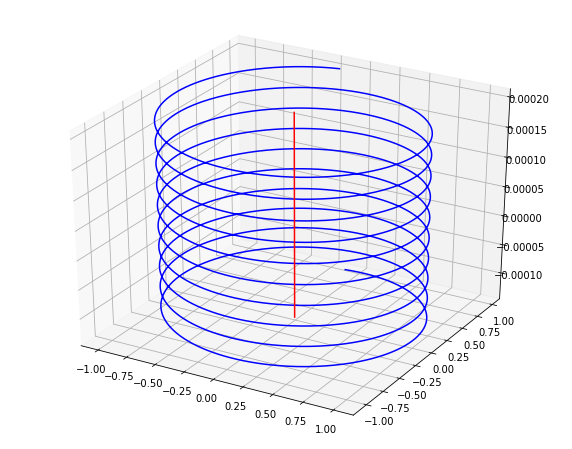

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(y[:,0], y[:,1], y[:,2], 'b')
ax.plot(y[:,6], y[:,7], y[:,8], 'r')

Let's do all the planets! To do this we'll download all the ephemeris files and extract the first point.

In [44]:
import requests
from six import StringIO
import re
from collections import OrderedDict


In [45]:
# read in the JPL ephemeris data
baseloc = '/home/awilson/code/solsym/solar_system/JPL_coordinates/'

jplfiles = OrderedDict() # use ordered dictionary so that planets are in the right order
jplfiles['Sun'] = 'sun.txt'
jplfiles['Mercury'] = 'mercury.txt'
jplfiles['Venus'] = 'venus.txt'
jplfiles['Earth'] = 'earthmoon.txt'
jplfiles['Mars'] = 'mars.txt'
jplfiles['Jupiter'] = 'jupiter.txt'
jplfiles['Saturn'] = 'saturn.txt'
jplfiles['Uranus'] = 'uranus.txt'
jplfiles['Neptune'] = 'neptune.txt'
jplfiles['Pluto'] = 'pluto.txt'
jpldata = OrderedDict()

#     jpleph = requests.get(baseurl.format(ofile))
#    content = re.findall(r'\$\$SOE(.*?)\$\$EOE', str(jpleph.content), flags=re.U|re.S|re.M)[0]
for oname, ofile in jplfiles.items():
    jpleph=open(baseloc+ofile)
    content=jpleph.read()
    content = re.findall(r'\$\$SOE(.*?)\$\$EOE', str(content), flags=re.U|re.S|re.M)[0]
    fp = StringIO(content)
    data = np.loadtxt(fp, delimiter=',', usecols=(0, 2, 3, 4, 5, 6, 7))
    jpldata[oname] = data


In [46]:
# mass ratios compared to the Sun
massratios = OrderedDict()
massratios['Sun'] =     1.
massratios['Mercury'] = 1./6023600.
massratios['Venus'] =   1./408523.71
massratios['Earth'] =   1./328900.56 # Earth + Moon system
massratios['Mars'] =    1./3098708.
massratios['Jupiter'] = 1./1047.3486
massratios['Saturn'] =  1./3497.898
massratios['Uranus'] =  1./22902.98
massratios['Neptune'] = 1./19412.24
massratios['Pluto'] =   1./1.35e8

# Gaussian gravitational constant
k = 0.01720209895 # (AU^3/d^2)^1/2
GM=np.zeros(len(massratios))
# G*M
i=0
for oname in massratios:
    GM[i]=massratios[oname]*k**2
    i+=1

In [47]:
for i, planet in enumerate(jpldata.keys()):
    print(jpldata[planet][0,1:])

[-7.13914713e-03 -2.79201983e-03  2.06182572e-04  5.37426141e-06
 -7.41096674e-06 -9.42288937e-08]
[-0.14786722 -0.44669298 -0.02313938  0.02117425 -0.00710539 -0.00252293]
[-7.25769364e-01 -2.52958224e-02  4.13780293e-02  5.18907060e-04
 -2.03135526e-02 -3.07268621e-04]
[-1.75689599e-01  9.65971638e-01  2.05024028e-04 -1.72246362e-02
 -3.02068484e-03 -7.00338913e-08]
[ 1.38322192e+00 -2.38017380e-02 -3.44118342e-02  7.53301337e-04
  1.51788877e-02  2.99658880e-04]
[ 3.99632106e+00  2.93256140e+00 -1.01616854e-01 -4.55837695e-03
  6.43986304e-03  7.53760202e-05]
[ 6.40141936e+00  6.56525104e+00 -3.68919311e-01 -4.28516469e-03
  3.88457903e-03  1.02516007e-04]
[ 1.44233814e+01 -1.37384407e+01 -2.37918365e-01  2.68385820e-03
  2.66501430e-03 -2.48407443e-05]
[ 1.68036276e+01 -2.49954506e+01  1.27483023e-01  2.58459114e-03
  1.76894147e-03 -9.62932102e-05]
[-9.88399740e+00 -2.79607971e+01  5.85101576e+00  3.04134897e-03
 -1.53962424e-03 -7.15681025e-04]


In [48]:


# set up the initial position of the Earth in units of AU and AU/day:
X = np.zeros(len(GM)*6)

for i, planet in enumerate(jpldata.keys()):
    X[6*i:6*(i+1)] = jpldata[planet][0,1:]

times = jpldata['Sun'][:,0]-jpldata['Sun'][0,0]
times = np.arange(0,1*365.,5)

y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)


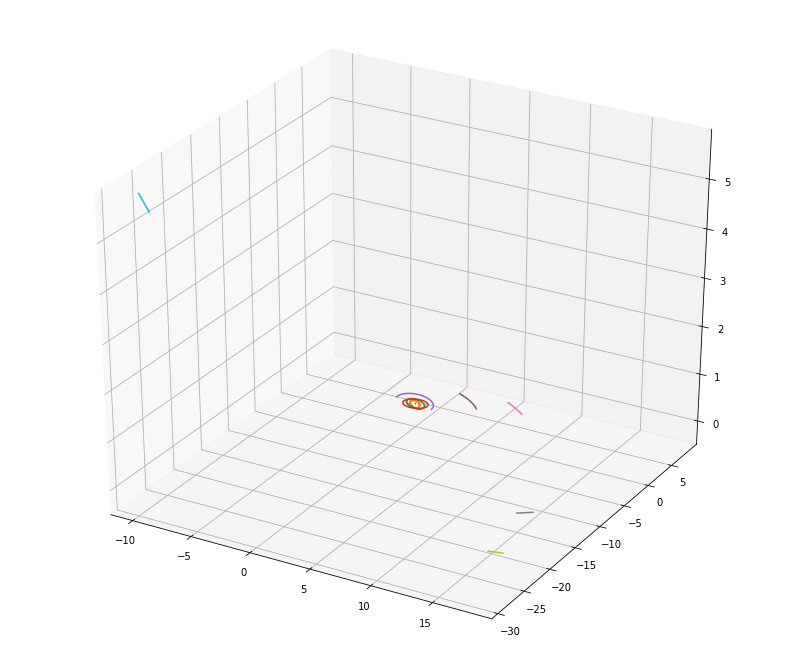

In [49]:
fig = pl.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(GM)):
    ax.plot(y[:,6*i], y[:,6*i+1], y[:,6*i+2])

##### Now we'll use try using [astropy](http://docs.astropy.org/en/stable/) (which itself uses [jplephem](https://pypi.python.org/pypi/jplephem)) to get solar system ephemeris values, so both these packages should be installed using, e.g,

```bash
pip install astropy
pip install jplephem
```

> Note: this requires astropy v. 2.0.3

To convert between equatorial coordinates returned by jplephem and ecliptic coordinates used in the solar system simulator we need to install [spicepy](http://spiceypy.readthedocs.io).

In [50]:
from astropy.coordinates import CartesianRepresentation,SphericalRepresentation, SphericalDifferential,CartesianDifferential,get_body_barycentric_posvel,BarycentricTrueEcliptic, BaseEclipticFrame,spherical_to_cartesian, cartesian_to_spherical, SkyCoord, FK5, HeliocentricTrueEcliptic # function to get positions and velocities
from astropy.time import Time, TimeDelta
from astropy.coordinates import solar_system_ephemeris
from astropy import units as u

# from spiceypy import sxform, mxvg

# some URLs for different ephemerides (these will be downloaded and cached on first use)
ephurls = {'de432s': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de432s.bsp',
           'de430': 'http://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de430.bsp',
           'de200': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de200.bsp',
           'de405': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de405.bsp',
           'de406s': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de406s.bsp',
           'de410': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de410.bsp',
           'de421': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de421.bsp'}

#starttime = Time('2000-01-01 00:00:00.00')
#starttime = Time('2000-01-01 00:00:00.00', scale='tdb')
starttime = Time(2451544.5, format='jd', scale='tdb')

# time step of 10 days
dt = TimeDelta(10.0, format='jd', scale='tdb')

# 3650 days
nsteps = 360

# the ephemerides in http://www.astro.gla.ac.uk/honours/labs/solar_system/JPL%20coordinates come from DE406,
# but we'll use the more up-to-date DE430

eph = 'de430'
solar_system_ephemeris.set(ephurls[eph])
# sph_coo=SphericalRepresentation(lon=0*u.deg,lat=0*u.deg,distance=0*u.km)
# car_coo=CartesianRepresentation(x=0*u.km,y=0*u.km,z=0*u.km)
# print out the available bodies
bodies = ['sun', 'mercury', 'venus', 'earth-moon-barycenter', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune', 'pluto']

ephemdata = OrderedDict()
ephem_ecl = OrderedDict()

for body in bodies:

    posvel = np.zeros([nsteps,6])# positions in ecliptic plane
    posecl=np.zeros([nsteps,3])
    
    curtime = starttime

    for i in range(nsteps):
#         get current position/velocity
        tpos, tvel = get_body_barycentric_posvel(body, curtime)

        posvel[i,0:3]=[tpos.x.value/149597870700*1000,tpos.y.value/149597870700*1000,tpos.z.value/149597870700*1000]
        posvel[i,3:6]=[tvel.x.value/149597870700*1000,tvel.y.value/149597870700*1000,tvel.z.value/149597870700*1000]

        #         sphpos=cartesian_to_spherical(tpos.x,tpos.y,tpos.z)

#         poseq=SkyCoord(tpos.x,tpos.y,tpos.z,frame='icrs',representation_type='cartesian',obstime=curtime)
# #change from from icrs to barycentric ecliptic    
#         pos1=poseq.transform_to(BarycentricTrueEcliptic(poseq.spherical))
#         pos1.representation_type='cartesian'
#         posecl[i,:]=[pos1.x.value/149597870700*1000,pos1.y.value/149597870700*1000,pos1.z.value/149597870700*1000]
        curtime += dt
#     print(d_r,d_th,d_ph)
    ephemdata[body]=posvel
#     ephem_ecl[body]=posecl


# for body in bodies:
#     poseq = []  # positions in equatorial plane
#     veleq = []  # velocities in equatorial plane
#     posecl = [] # positions in ecliptic plane
#     velecl = [] # velocities in ecliptic plane

#     curtime = starttime

#     for i in range(nsteps):
#         tpos, tvel = get_body_barycentric_posvel(body, curtime)
#         # convert (equatorial) positions into AU
#         poseq.append(tpos.xyz)
    
#         # convert (equatorial) velocities into AU/day
#         veleq.append(tvel.xyz)
    
#         # get equatorial state vector
#         statevec = [poseq[-1][0].value, poseq[-1][1].value, poseq[-1][2].value,
#                     veleq[-1][0].value, veleq[-1][1].value, veleq[-1][2].value]
    
#         # get transformation matrix
#         trans = sxform("J2000", "ECLIPJ2000", curtime.value)
    
#         # transform state vector to ecliptic
#         statevececl = mxvg(trans, statevec, 6, 6)
    
#         posecl.append([statevececl[0]*u.km, statevececl[1]*u.km, statevececl[2]*u.km])
#         velecl.append([statevececl[3]*u.km/u.d, statevececl[4]*u.km/u.d, statevececl[5]*u.km/u.d])
    
#         curtime += dt
    
#     ephemdata[body] = np.hstack((np.array([[pv[0].to('AU').value, pv[1].to('AU').value, pv[2].to('AU').value] for pv in posecl]),
#                                  np.array([[pv[0].to('AU/d').value, pv[1].to('AU/d').value, pv[2].to('AU/d').value] for pv in velecl])))

In [51]:
from astropy.coordinates import CartesianRepresentation,SphericalRepresentation, SphericalDifferential,CartesianDifferential,get_body_barycentric_posvel,BarycentricTrueEcliptic, BaseEclipticFrame,spherical_to_cartesian, cartesian_to_spherical, SkyCoord, FK5, HeliocentricTrueEcliptic # function to get positions and velocities
from astropy.time import Time, TimeDelta
from astropy.coordinates import solar_system_ephemeris

starttime = Time('2000-01-01 00:00:00.000', format='iso', scale='utc')

In [52]:
print(starttime)

2000-01-01 00:00:00.000


In [53]:
starttime.format='isot'

In [54]:
# print(ephem_ecl['sun'][0])
# veleq1=SkyCoord(,frame='icrs')
# xx=veleq.transform_to(BarycentricTrueEcliptic(poseq.spherical))

In [55]:
# # set up the initial position of the Earth in units of AU and AU/day:
# X = np.zeros(len(GM)*6)
# for i, planet in enumerate(bodies):
#     X[6*i:6*(i+1)] = ephemdata[planet][0,:]

# times = np.arange(0., nsteps*10, 10)

# y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)

In [56]:
np.size(y)/365

12.0

In [57]:
# y_ecl=np.zeros([nsteps,10,3])
# tpos=[]
# for j in range(10):
#     curtime=starttime
#     for i in range(nsteps):
#         tpos=y[i,6*j:6*j+3]

#         poseq=SkyCoord(tpos[0],tpos[1],tpos[2],frame='icrs',representation_type='cartesian',obstime=curtime)
# #change from from icrs to barycentric ecliptic    
#         pos1=poseq.transform_to(BarycentricTrueEcliptic(poseq.spherical))
#         pos1.representation_type='cartesian'
#         y_ecl[i,j,0:3]=[pos1.x.value,pos1.y.value,pos1.z.value]
    
#     curtime += dt
# #     print(d_r,d_th,d_ph)

In [58]:
print(nsteps,i)

360 359


In [59]:
# fig = pl.figure(figsize=(14,12))
# ax = fig.add_subplot(111, projection='3d')
# for i in range(len(GM)):
#     ax.plot(y[:,6*i], y[:,6*i+1], y[:,6*i+2])


In [60]:
# fig = pl.figure(figsize=(14,12))
# ax = fig.add_subplot(111, projection='3d')
# for body in bodies:
#     ax.plot(ephemdata[body][:,0],ephemdata[body][:,1],ephemdata[body][:,2])
    

In [61]:
# fig = pl.figure(figsize=(14,12))
# ax = fig.add_subplot(111, projection='3d')

# for i in range(len(GM)):
#     ax.plot(y_ecl[:,i,0], y_ecl[:,i,1], y_ecl[:,i,2])
#     ax.set(xlim=[-1,1],ylim=[-1,1],zlim=[-1,1])    
# ax.view_init(90,0)

In [62]:
# fig = pl.figure(figsize=(14,12))
# ax = fig.add_subplot(111, projection='3d')
# for body in bodies:
#     ax.plot(ephem_ecl[body][:,0],ephem_ecl[body][:,1],ephem_ecl[body][:,2])
    
# ax.set(xlim=[-1,1],ylim=[-1,1],zlim=[-1,1])
# ax.view_init(90,0)

In [63]:
# fig=pl.figure(figsize=(14,12))
# ax = fig.add_subplot(111)
# print(bodies)
# i=5
# body=bodies[i]
# x_diff=(ephem_ecl[body][:,0]-y_ecl[:,i,0])
# y_diff=(ephem_ecl[body][:,1]-y_ecl[:,i,1])
# z_diff=(ephem_ecl[body][:,2]-y_ecl[:,i,2])
# ax.plot(np.sqrt(x_diff**2+y_diff**2+z_diff**2))
# pl.title(body)
# pl.ylabel('Total displacement from ephemeris (AU)')
# pl.xlabel('Time (10days)')

In [64]:
X = np.zeros(len(GM)*6)
for i, planet in enumerate(bodies):
    X[6*i:6*(i+1)] = ephemdata[planet][0,:]

times = np.arange(0., nsteps*10, 10)

y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)

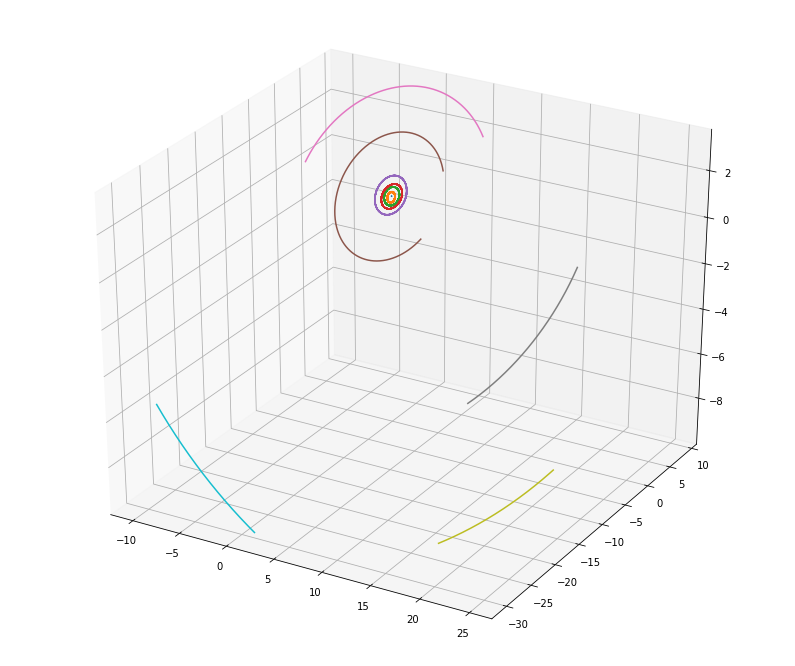

In [79]:
 fig = pl.figure(figsize=(14,12))
 ax = fig.add_subplot(111, projection='3d')
 for i in range(len(GM)):
     ax.plot(y[:,6*i], y[:,6*i+1], y[:,6*i+2])

In [66]:
print(X[0:6])

[-7.13914338e-03 -2.64364330e-03 -9.21431667e-04  5.37426094e-06
 -6.76194582e-06 -3.03436581e-06]


In [116]:
y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)

In [140]:
#set initial Positions for the single sun system
for i, planet in enumerate(jpldata.keys()):
    X[6*i:6*(i+1)] = jpldata[planet][0,1:]
#make new array
Z=np.zeros([6*10])
#set separation/velocity
separation=0.4/2
binary_vel=0.01 
#copy over the planets
Z[6:9*6]=X[6:9*6]
#star 1 has offset of negative in X axis
Z[0]=X[0]-separation
#rest is same as Sun
Z[1:6]=X[1:6]
#star 1 has a velocity of negative in the y axis
Z[4]=X[4]-binary_vel
#opposite intial condition for star 2 x axis
Z[54]=X[0]+separation
#rest is same as sun
Z[55:60]=X[1:6]
#y velocity opposite also.
Z[58]=X[4]+binary_vel

#set masses, 0 and 9 for the 2 stars 1:9 for 8 planets
GMZ=np.zeros([10])
GMZ[2:10]=GM[1:9]
GMZ[0]=GM[0]*0.5
GMZ[9]=GM[0]*0.5

#set sim timer
times = np.arange(0., nsteps, 5)
#run sim
yz, infodict = odeint(grav, Z, times, args=(GMZ,), full_output=True)

print(yz[:,0]-yz[:,6])

[-0.05927192 -0.15478228 -0.22477112 -0.26130944 -0.25763268 -0.23345291
 -0.28606616 -0.34338626 -0.31613943 -0.21252567 -0.05372471  0.12847127
  0.27627037  0.39366488  0.50581517  0.61805247  0.66085728  0.58650758
  0.50392034  0.4417652   0.40182518  0.38358182  0.38701204  0.4129248
  0.46269584  0.53519792  0.59888613  0.54695924  0.44332723  0.35749694
  0.29641272  0.25918537  0.24498984  0.25391556  0.28694355  0.34488511
  0.41851504  0.42832753  0.33041551  0.23132614  0.15630294  0.10597099
  0.0791919   0.07555494  0.09561433  0.14054685  0.20881158  0.2663525
  0.20695594  0.10038715  0.01271643 -0.04984633 -0.08828863 -0.10345708
 -0.09526746 -0.06274427 -0.00516425  0.06732155  0.07194832 -0.02807767
 -0.12712518 -0.20186135 -0.25185877 -0.27825665 -0.28144391 -0.26084391
 -0.21528665 -0.14660212 -0.09134547 -0.15457908 -0.26098757 -0.34784763]


In [136]:
y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)

[(-1, 1),
 Text(0.5, 0, 'z'),
 (-1, 1),
 Text(0.5, 0, 'y'),
 (-1, 1),
 Text(0.5, 0, 'x')]

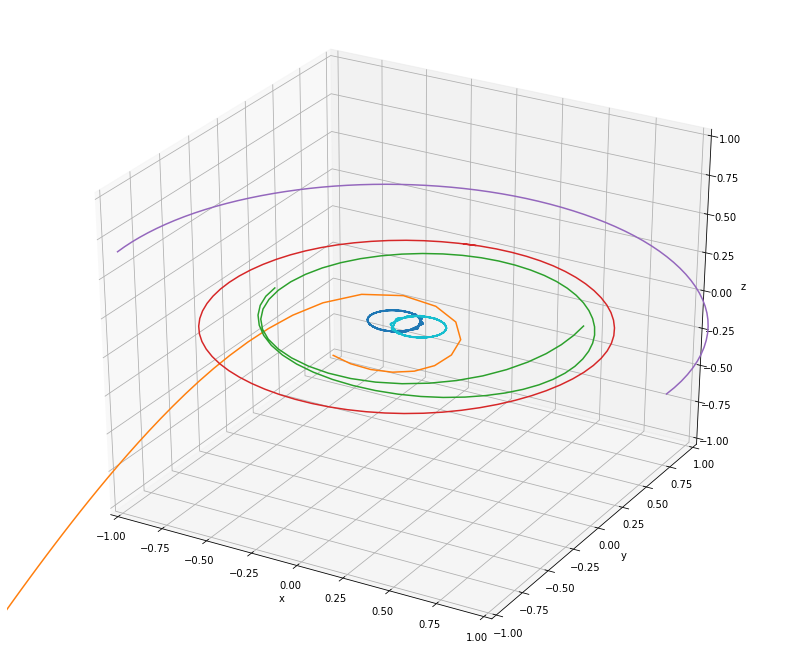

In [141]:
fig = pl.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(GMZ)):
     ax.plot(yz[:,6*i], yz[:,6*i+1], yz[:,6*i+2])
    
ax.set(xlim=[-1,1],ylim=[-1,1],zlim=[-1,1],xlabel='x',ylabel='y',zlabel='z')

[(-1, 1), (-1, 1), (-1, 1)]

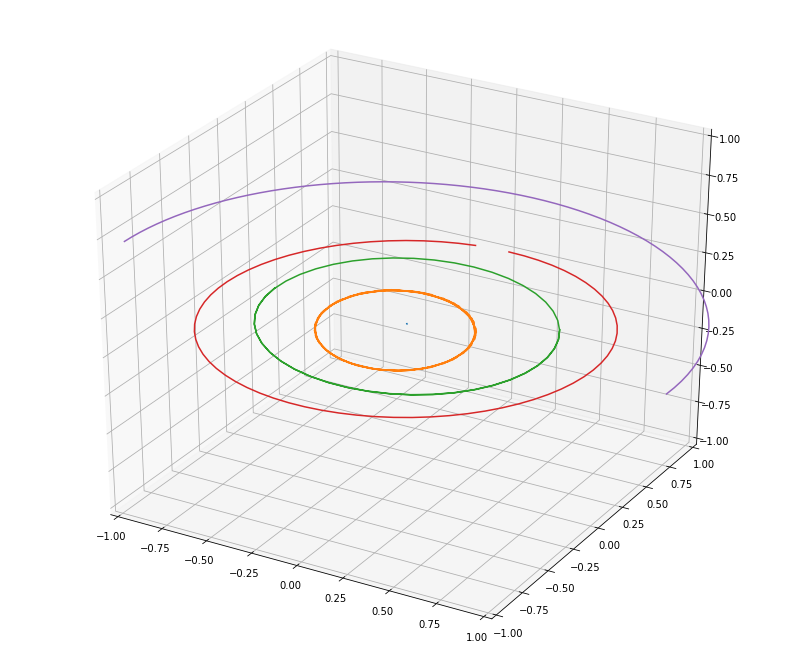

In [137]:
fig = pl.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(GMZ)):
     ax.plot(y[:,6*i], y[:,6*i+1], y[:,6*i+2])
    
ax.set(xlim=[-1,1],ylim=[-1,1],zlim=[-1,1])